In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# pip install pandas_ta

In [3]:
import pandas_ta as ta

In [4]:
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [5]:
# Everything concerning USDTRY pair is done here, after testing the models CHECK THIS PART!
bist_daily = pd.read_csv("datasets/bist_100_daily.csv")
usdtry_daily = pd.read_csv('datasets/USDTRY_daily.csv')
usdtry_daily = usdtry_daily[["Date","USDTRY_Close"]]
usdtry_daily["Date"]=pd.to_datetime(usdtry_daily["Date"])
bist_daily["Date"] = pd.to_datetime(bist_daily["Date"])
bist_daily = bist_daily.merge(usdtry_daily, how='inner',on="Date")


# Extract the number of rows and columns by using the shape of the data.
numRows,numColumns = bist_daily.shape
# Extract the time interval.
last_date, first_date = bist_daily.iloc[0].Date, bist_daily.iloc[-1].Date
# Check the availability of the data.
na_cols = bist_daily.columns[bist_daily.isna().any()].tolist()

# Print the information.
print(f"There are {numRows} rows and {numColumns} columns in the initial dataset.")
print(f"The data represents the time frame between the dates '{last_date}' and '{first_date}'.")
if not na_cols:
    print("There are no NA rows.")
else:
    print(f"Columns in the dataset which include NA rows: {na_cols}.")
# Convert columns to numeric values
column_names = ["Price", "Open", "High", "Low"]
for column in column_names:
    bist_daily[column] = bist_daily[column].str.replace(',', '')
    bist_daily[column] = pd.to_numeric(bist_daily[column])
# CONVERT TO DATETIME FORMAT AND SORT DATA BY DATE
bist_daily.Date = pd.to_datetime(bist_daily.Date)
bist_daily.sort_values(by="Date", ignore_index=True,inplace=True)
bist_daily.set_index(pd.DatetimeIndex(bist_daily["Date"]), inplace=True)
bist_daily.rename(columns={"Price": "close"},inplace=True)
# Calculate Returns and append to the df DataFrame
# CUMLOGRET_1 and CUMPCTRET_1 are added (NaN values exists)
bist_daily.ta.log_return(cumulative=True, append=True)
bist_daily.ta.percent_return(cumulative=True, append=True)
# Returns a list of indicators and utility functions (to check in future)
ind_list = bist_daily.ta.indicators(as_list=True)
# RSI_14, MACD_12_26_9, MACDh_12_26_9 and MACDs_12_26_9 are added (NaN values exists)
bist_daily.ta.rsi(append=True)
bist_daily.ta.macd(append=True)
# SMA values are added (use ta in the future)
sma_values = [5, 10, 15] 
for i in sma_values:
    bist_daily['SMA'+str(i)] = bist_daily['close'].rolling(window=i).mean()
# Remove all NaN value rows
bist_daily.dropna(inplace=True)
bist_daily

There are 4285 rows and 8 columns in the initial dataset.
The data represents the time frame between the dates '2019-12-02 00:00:00' and '2000-01-05 00:00:00'.
There are no NA rows.


date    close     open     high      low     Vol. Change %  \
date                                                                          
2000-02-29 2000-02-29   159.46   153.15   159.46   151.12   38.20M    4.12%   
2000-03-02 2000-03-02   169.40   171.99   174.08   166.83   60.08M   -1.51%   
2000-03-03 2000-03-03   167.84   169.40   170.67   163.96   53.29M   -0.92%   
2000-03-07 2000-03-07   172.23   165.63   172.23   163.13   33.31M    3.98%   
2000-03-08 2000-03-08   173.44   172.23   175.01   169.28   44.39M    0.70%   
...               ...      ...      ...      ...      ...      ...      ...   
2019-08-01 2019-08-01  1019.00  1013.42  1021.83  1010.93    1.04B   -0.18%   
2019-08-02 2019-08-02   996.79  1015.08  1017.07   996.30  970.54M   -2.18%   
2019-10-01 2019-10-01  1038.77  1052.75  1052.97  1031.89    1.81B   -1.10%   
2019-11-01 2019-11-01   984.63   986.90   988.14   976.79    1.14B   -0.01%   
2019-12-02 2019-12-02  1080.04  1073.50  1082.10  1073.18    2.19B    1.03%   

           USDTRY_Close  CUMLOGRET_1  CUMPCTRET_1     RSI_14  MACD_12_26_9  \
date                                                                         
2000-02-29       0,5743    -0.059997    -0.031662  50.482972     -7.536726   
2000-03-02       0,5592     0.000472     0.030673  57.007643     -5.687707   
2000-03-03       0,5771    -0.008779     0.021464  55.765721     -4.298673   
2000-03-07       0,6214     0.017040     0.047620  58.505269     -2.811211   
2000-03-08       0,6420     0.024041     0.054646  59.254312     -1.517260   
...                 ...          ...          ...        ...           ...   
2019-08-01       5,4811     1.794787     2.848509  56.453510     -2.625148   
2019-08-02       5,2474     1.772750     2.826713  51.628336     -1.558935   
2019-10-01       5,4168     1.814002     2.868828  58.796876      2.643014   
2019-11-01       5,4550     1.760476     2.816709  48.760664      1.586160   
2019-12-02       5,2516     1.852963     2.913608  61.298088      8.351118   

            MACDh_12_26_9  MACDs_12_26_9      SMA5    SMA10       SMA15  
date                                                                     
2000-02-29       2.021502      -9.558229   149.956  150.081  152.436667  
2000-03-02       3.096417      -8.784124   156.942  151.187  153.030000  
2000-03-03       3.588361      -7.887034   161.206  152.629  153.666000  
2000-03-07       4.060658      -6.871869   164.416  154.488  154.749333  
2000-03-08       4.283688      -5.800948   168.474  157.263  156.154000  
...                   ...            ...       ...      ...         ...  
2019-08-01       0.532934      -3.158082   983.092  961.746  988.730667  
2019-08-02       1.279317      -2.838253  1001.758  967.324  985.630000  
2019-10-01       4.385014      -1.741999  1010.040  977.668  984.826667  
2019-11-01       2.662527      -1.076367  1006.564  981.690  981.041333  
2019-12-02       7.541988       0.809130  1023.846  995.515  983.357333  

[4252 rows x 17 columns]

{1: 2938, 2: 308, 3: 775, 4: 125, 5: 64, 6: 15, 7: 10, 10: 3, 11: 3, 12: 2, 28: 1, 29: 2, 31: 4, 60: 1}


<BarContainer object of 14 artists>

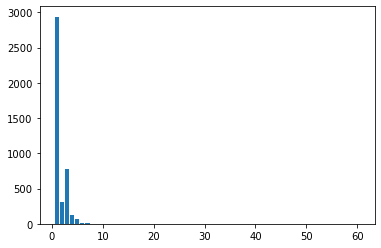

In [6]:
diff = [] 
for date1, date2 in zip(bist_daily["date"][:-1], bist_daily["date"][1:]): 
    diff.append((date2-date1).days) 
unique, counts = np.unique(np.asarray(diff), return_counts=True) 
count_dict = dict(zip(unique, counts)) 
print(count_dict) 
plt.bar(unique,counts)

In [7]:
# edit Vol. column

from operator import itemgetter

vols = bist_daily['Vol.'].to_list()
#[vol[-1] for vol in vols]
#list(filter(lambda vol: "-" in vol,enumerate(vols)))

indexToRemove = bist_daily.iloc[list(map(itemgetter(0),filter(lambda vol: "-" in vol,enumerate(vols))))].index
bist_daily.drop(indexToRemove,inplace=True)
bist_daily['Vol.'] = bist_daily['Vol.'].apply(
    lambda x: float(x[:-1])*(10**6) if x[-1]=="M" else (float(x[:-1])*(10**9) if x[-1]=="B" else "ERROR")).astype("int")
bist_daily

date    close     open     high      low        Vol.  \
date                                                                    
2000-02-29 2000-02-29   159.46   153.15   159.46   151.12    38200000   
2000-03-02 2000-03-02   169.40   171.99   174.08   166.83    60080000   
2000-03-03 2000-03-03   167.84   169.40   170.67   163.96    53290000   
2000-03-07 2000-03-07   172.23   165.63   172.23   163.13    33310000   
2000-03-08 2000-03-08   173.44   172.23   175.01   169.28    44390000   
...               ...      ...      ...      ...      ...         ...   
2019-08-01 2019-08-01  1019.00  1013.42  1021.83  1010.93  1040000000   
2019-08-02 2019-08-02   996.79  1015.08  1017.07   996.30   970540000   
2019-10-01 2019-10-01  1038.77  1052.75  1052.97  1031.89  1810000000   
2019-11-01 2019-11-01   984.63   986.90   988.14   976.79  1140000000   
2019-12-02 2019-12-02  1080.04  1073.50  1082.10  1073.18 -2147483648   

           Change % USDTRY_Close  CUMLOGRET_1  CUMPCTRET_1     RSI_14  \
date                                                                    
2000-02-29    4.12%       0,5743    -0.059997    -0.031662  50.482972   
2000-03-02   -1.51%       0,5592     0.000472     0.030673  57.007643   
2000-03-03   -0.92%       0,5771    -0.008779     0.021464  55.765721   
2000-03-07    3.98%       0,6214     0.017040     0.047620  58.505269   
2000-03-08    0.70%       0,6420     0.024041     0.054646  59.254312   
...             ...          ...          ...          ...        ...   
2019-08-01   -0.18%       5,4811     1.794787     2.848509  56.453510   
2019-08-02   -2.18%       5,2474     1.772750     2.826713  51.628336   
2019-10-01   -1.10%       5,4168     1.814002     2.868828  58.796876   
2019-11-01   -0.01%       5,4550     1.760476     2.816709  48.760664   
2019-12-02    1.03%       5,2516     1.852963     2.913608  61.298088   

            MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9      SMA5    SMA10  \
date                                                                        
2000-02-29     -7.536726       2.021502      -9.558229   149.956  150.081   
2000-03-02     -5.687707       3.096417      -8.784124   156.942  151.187   
2000-03-03     -4.298673       3.588361      -7.887034   161.206  152.629   
2000-03-07     -2.811211       4.060658      -6.871869   164.416  154.488   
2000-03-08     -1.517260       4.283688      -5.800948   168.474  157.263   
...                  ...            ...            ...       ...      ...   
2019-08-01     -2.625148       0.532934      -3.158082   983.092  961.746   
2019-08-02     -1.558935       1.279317      -2.838253  1001.758  967.324   
2019-10-01      2.643014       4.385014      -1.741999  1010.040  977.668   
2019-11-01      1.586160       2.662527      -1.076367  1006.564  981.690   
2019-12-02      8.351118       7.541988       0.809130  1023.846  995.515   

                 SMA15  
date                    
2000-02-29  152.436667  
2000-03-02  153.030000  
2000-03-03  153.666000  
2000-03-07  154.749333  
2000-03-08  156.154000  
...                ...  
2019-08-01  988.730667  
2019-08-02  985.630000  
2019-10-01  984.826667  
2019-11-01  981.041333  
2019-12-02  983.357333  

[4233 rows x 17 columns]

In [8]:
# seeding an arbitrary number to get same results in multiple runs
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Seed:", manualSeed)

Seed: 999


In [9]:
# getting number of GPUs from cuda
ngpu = torch.cuda.device_count()
print("Count of available GPUs:", ngpu)

Count of available GPUs: 0


In [10]:
# printing the name of available GPUs
for i in range(ngpu):
    print("GPU {}: {}".format(i+1, torch.cuda.get_device_name(i)))

In [11]:
# batch size for the training
batch_size = 64

# optimizer rates
optimizer_betas = (0.9, 0.999)
learning_rate = 5e-4

# number of epochs
num_epochs = 300

# evaluate after evaluation_epoch_num epochs
evaluation_epoch_num = 5

# decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [12]:
class TimeseriesDataset(Dataset):
    def __init__(self, data_frame, sequence_length=2):
        self.data = torch.tensor(data_frame.values)
        self.sequence_length = sequence_length

    def __len__(self):
        return self.data.shape[0] - self.sequence_length + 1

    def __getitem__(self, index):
        return self.data[index: index + self.sequence_length].float()
    
    # Non-overlapping series
    # def __getitem__(self, index):
    #     return self.data[index * self.sequence_length: (index+1) * self.sequence_length]

In [13]:
# create pytorch dataset from the pandas DataFrame

# TODO: Convert change(%) and Volume columns to numeric values
columns_used_in_training = ["close", "open", "high", "low", "CUMLOGRET_1", "RSI_14", "MACD_12_26_9", "SMA5"]
# input dimension of the generator
data_dimension = len(columns_used_in_training)
# sequence length of input data
sequence_length = 7

train_data, rest_data = train_test_split(bist_daily[columns_used_in_training], test_size=0.2, shuffle=False)

scaler = MinMaxScaler()
scaler.fit(train_data)
train_data[train_data.columns] = scaler.transform(train_data)
rest_data[rest_data.columns] = scaler.transform(rest_data)

validation_data, test_data = train_test_split(rest_data, test_size=0.5, shuffle=False)

train_dataset = TimeseriesDataset(train_data, sequence_length)
test_dataset = TimeseriesDataset(test_data, sequence_length)
validation_dataset = TimeseriesDataset(validation_data, sequence_length)

# create the dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)
real_data_sample = next(iter(train_dataloader))
print("Real data sample shape:", real_data_sample.shape)

Real data sample shape: torch.Size([64, 7, 8])


In [14]:
class Generator(nn.Module):
    def __init__(self, hidden_size):
        super(Generator, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=data_dimension, hidden_size=hidden_size, num_layers=1, dropout=0.2, batch_first=True)
        self.linear = nn.Linear(hidden_size, data_dimension)
        self.drop = nn.Dropout(0.2)

    def forward(self, input_sequences):
        input_sequences = self.drop(input_sequences)
        lstm_output, hidden_cell = self.lstm(input_sequences)
        res = self.linear(hidden_cell[0][-1])
        res = res.view(res.shape[0], 1, -1)
        return res

In [15]:
class Discriminator(nn.Module):
    def __init__(self, hidden_size):
        super(Discriminator, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=data_dimension, hidden_size=hidden_size, num_layers=1, dropout=0.2, batch_first=True)
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid() 
        )
        self.drop = nn.Dropout(0.2)

    def forward(self, input_sequences):
        input_sequences = self.drop(input_sequences)
        lstm_output, hidden_cell = self.lstm(input_sequences)
        res = self.linear(hidden_cell[0][-1])
        res = res.view(res.shape[0], 1, -1)
        return res

In [16]:
def model_rmse(model, dataloader, epoch, plot_graph=False, plot_title="Validation Predictions"):
    rmse = 0
    squared_error_list = []
    real_data_list = []
    predicted_data_list = []
    for i, sequence_batch in enumerate(dataloader):
        with torch.no_grad():
            real_sequence = sequence_batch
            # Assign first t values
            generator_input_sequence = sequence_batch[:,:-1].to(device)
            real_values = sequence_batch[:,-1:]
            #  Generate (t+1)th value from first t values
            predicted_values = generator(generator_input_sequence).cpu()
            real_data_list.append(real_values)
            predicted_data_list.append(predicted_values)
    
    real_data = torch.cat(real_data_list, 0)
    predicted_data = torch.cat(predicted_data_list, 0)
    
    # Unscale data
    df_pred = pd.DataFrame(predicted_data.view(-1,len(columns_used_in_training)),columns=columns_used_in_training)
    df_pred_unscaled = pd.DataFrame(scaler.inverse_transform(df_pred),columns=columns_used_in_training)
    df_real = pd.DataFrame(real_data.view(-1,len(columns_used_in_training)),columns=columns_used_in_training)
    df_real_unscaled = pd.DataFrame(scaler.inverse_transform(df_real),columns=columns_used_in_training)
    
    if plot_graph:
        if not os.path.exists('./plots/'):
            os.makedirs('./plots/')
        
        # TODO: get x values and plot prediction of multiple columns
        fig = plt.figure(figsize=(16,8))
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(plot_title)
        plt.plot(df_real_unscaled['close'],label="Real")
        plt.plot(df_pred_unscaled['close'],label="Predicted")
        # plt.ylim(bottom=0)
        plt.legend()
        fig.savefig('./plots/plt_epoch_{}.png'.format(epoch))
        plt.close(fig)
        
    squared_errors = (df_real_unscaled['close'] - df_pred_unscaled['close'])**2
    rmse = np.sqrt(squared_errors.mean())
    return rmse

In [17]:
# TODO: weight initialization of models

In [18]:
generator = Generator(hidden_size=data_dimension*2).to(device)
discriminator = Discriminator(hidden_size=data_dimension*2).to(device)
print("Generator and discriminator are initialized")

Generator and discriminator are initialized


C:\anaconda\envs\datacourse\lib\site-packages\torch\nn\modules\rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [19]:
criterion = nn.BCELoss()
optimizer_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=optimizer_betas)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=optimizer_betas)

real_label = 1.
fake_label = 0.

In [20]:
if not os.path.exists('./models/'):
    os.makedirs('./models/')

In [21]:
evaluation_metrics = {"gen_loss":[], "disc_loss":[], "rmse":[]}
                      
print("Training is started")
for epoch in range(num_epochs):
    for i, sequence_batch in enumerate(train_dataloader):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Training with real batch
            discriminator.zero_grad()
            # Format batch
            real_sequence = sequence_batch.to(device)
            batch_size = real_sequence.size(0)
            real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            discriminator_output_real = discriminator(real_sequence).view(-1)
            # Calculate loss on all-real batch
            discriminator_error_real = criterion(discriminator_output_real, real_labels)
            # Calculate gradients for D in backward pass
            discriminator_error_real.backward()

            ## Training with fake batch
            # Assign first t values
            generator_input_sequence = sequence_batch[:,:-1].to(device)
            #  Generate (t+1)th value from first t values
            generated_values = generator(generator_input_sequence)
            fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
            # Concat first t real values and generated (t+1)th values
            generator_result_concat = torch.cat((generator_input_sequence, generated_values.detach()), 1)
            # Classify all fake batch with D
            discriminator_output_fake = discriminator(generator_result_concat).view(-1)
            # Calculate D's loss on the all-fake batch
            discriminator_error_fake = criterion(discriminator_output_fake, fake_labels)
            # Calculate the gradients for this batch
            discriminator_error_fake.backward()
            # Add the gradients from the all-real and all-fake batches
            discriminator_error = discriminator_error_real + discriminator_error_fake
            # Update D
            optimizer_discriminator.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            generator.zero_grad()
            real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            # Since we just updated D, perform another forward pass of all-fake batch through D
            generator_result_concat_grad = torch.cat((generator_input_sequence, generated_values), 1)
            discriminator_output_fake = discriminator(generator_result_concat_grad).view(-1)
            # Calculate G's loss based on this output
            generator_error = criterion(discriminator_output_fake, real_labels)
            # Calculate gradients for G
            generator_error.backward()
            # Update G
            optimizer_generator.step()
    if (epoch+1) % 5 == 0 or epoch+1 == 1:
        rmse = model_rmse(generator, validation_dataloader, epoch=(epoch+1), plot_graph=True)
        evaluation_metrics["rmse"].append(rmse)
        evaluation_metrics["gen_loss"].append(generator_error.item())
        evaluation_metrics["disc_loss"].append(discriminator_error.item())
        print('\n[{}/{}]\tDiscriminator Loss: {:.4f}\tGenerator Loss: {:.4f}   \tRMSE:{:.4f}'
                  .format(epoch+1, num_epochs, discriminator_error.item(), generator_error.item(), rmse))
        for col_name, real, generated in zip(columns_used_in_training, sequence_batch[0][-1], generated_values[0][0]):
            print(f"{col_name} | Real:{real:.4f} / Generated:{generated:.4f}")
        save_path = os.path.join("./models/","model_epoch_{}.pt".format(epoch+1))
        torch.save({
            'epoch': epoch+1,
            'generator_model_state_dict': generator.state_dict(),
            'discriminator_model_state_dict': discriminator.state_dict(),
            'optimizer_generator_state_dict': optimizer_generator.state_dict(),
            'optimizer_discriminator_state_dict': optimizer_discriminator.state_dict(),
            'discriminator_loss': discriminator_error,
            'generator_loss': generator_error,
            }, save_path)

Training is started

[1/300]	Discriminator Loss: 1.3682	Generator Loss: 0.6711   	RMSE:585.9690
close | Real:0.2023 / Generated:0.0488
open | Real:0.2009 / Generated:0.2324
high | Real:0.1991 / Generated:-0.0910
low | Real:0.2055 / Generated:0.0731
CUMLOGRET_1 | Real:0.4804 / Generated:0.1446
RSI_14 | Real:0.5618 / Generated:0.2045
MACD_12_26_9 | Real:0.6826 / Generated:0.1626
SMA5 | Real:0.2081 / Generated:0.1139

[5/300]	Discriminator Loss: 1.3928	Generator Loss: 0.6920   	RMSE:962.1248
close | Real:0.1830 / Generated:-0.2272
open | Real:0.1793 / Generated:0.1146
high | Real:0.1795 / Generated:0.1866
low | Real:0.1853 / Generated:0.8478
CUMLOGRET_1 | Real:0.4531 / Generated:0.0652
RSI_14 | Real:0.6212 / Generated:0.1861
MACD_12_26_9 | Real:0.6475 / Generated:0.5120
SMA5 | Real:0.1767 / Generated:-0.1321

[10/300]	Discriminator Loss: 1.3838	Generator Loss: 0.6975   	RMSE:384.8861
close | Real:0.6794 / Generated:0.3600
open | Real:0.6781 / Generated:0.5440
high | Real:0.6801 / Generate


[105/300]	Discriminator Loss: 1.3842	Generator Loss: 0.7016   	RMSE:103.2770
close | Real:0.9020 / Generated:0.7467
open | Real:0.8960 / Generated:1.2790
high | Real:0.9050 / Generated:0.6334
low | Real:0.9114 / Generated:0.5061
CUMLOGRET_1 | Real:0.9631 / Generated:0.8834
RSI_14 | Real:0.5304 / Generated:0.0153
MACD_12_26_9 | Real:0.6706 / Generated:0.6219
SMA5 | Real:0.9054 / Generated:0.6067

[110/300]	Discriminator Loss: 1.3830	Generator Loss: 0.6927   	RMSE:139.3392
close | Real:0.2187 / Generated:0.1511
open | Real:0.2061 / Generated:-0.0861
high | Real:0.2152 / Generated:0.0834
low | Real:0.2127 / Generated:0.1719
CUMLOGRET_1 | Real:0.5021 / Generated:0.3761
RSI_14 | Real:0.4867 / Generated:0.8107
MACD_12_26_9 | Real:0.5534 / Generated:0.5912
SMA5 | Real:0.2078 / Generated:0.0290

[115/300]	Discriminator Loss: 1.3901	Generator Loss: 0.6898   	RMSE:82.4079
close | Real:0.1382 / Generated:0.1600
open | Real:0.1427 / Generated:0.1869
high | Real:0.1393 / Generated:0.2399
low | Rea


[210/300]	Discriminator Loss: 1.3825	Generator Loss: 0.6917   	RMSE:152.6497
close | Real:0.5958 / Generated:0.6296
open | Real:0.5923 / Generated:0.6256
high | Real:0.5943 / Generated:0.8092
low | Real:0.6021 / Generated:0.6138
CUMLOGRET_1 | Real:0.8180 / Generated:0.9726
RSI_14 | Real:0.7342 / Generated:0.7428
MACD_12_26_9 | Real:0.8367 / Generated:0.6932
SMA5 | Real:0.6030 / Generated:0.5076

[215/300]	Discriminator Loss: 1.4002	Generator Loss: 0.6988   	RMSE:263.5844
close | Real:0.0461 / Generated:-0.0692
open | Real:0.0531 / Generated:0.1510
high | Real:0.0496 / Generated:0.2429
low | Real:0.0487 / Generated:-0.0212
CUMLOGRET_1 | Real:0.1719 / Generated:0.4864
RSI_14 | Real:0.5427 / Generated:0.3436
MACD_12_26_9 | Real:0.7019 / Generated:0.6019
SMA5 | Real:0.0502 / Generated:-0.0136

[220/300]	Discriminator Loss: 1.3940	Generator Loss: 0.7019   	RMSE:111.3125
close | Real:0.7447 / Generated:0.7110
open | Real:0.7492 / Generated:0.5835
high | Real:0.7646 / Generated:0.9748
low | 

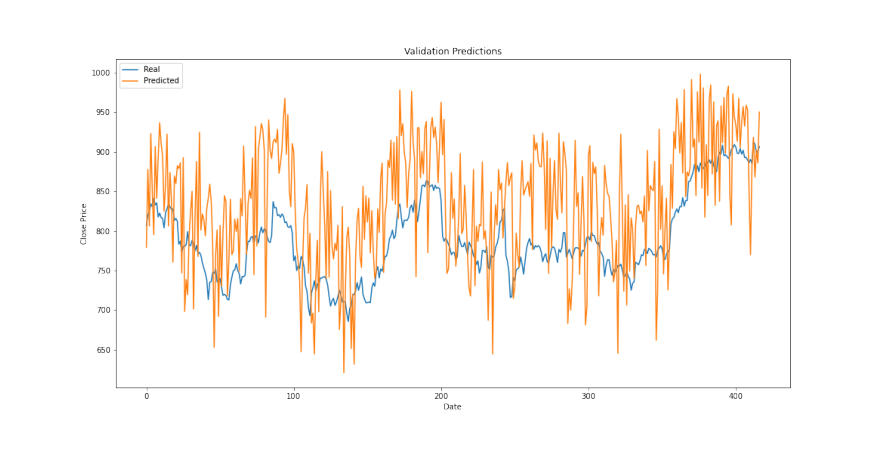

In [22]:
images = []
num_epochs = 295
for epoch in range(num_epochs):
    if (epoch+1)%evaluation_epoch_num == 0 or epoch == 0 or epoch == (num_epochs-1):
        image_path = os.path.join('./plots/', f'plt_epoch_{epoch+1}.png')
        image = plt.imread(image_path)
        images.append(image)
#%%capture
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(16,8))
plt.axis("off")

all_images = [[plt.imshow(image, animated=True)] for image in images]
plt.rcParams['animation.embed_limit'] = 2**32
ani = animation.ArtistAnimation(fig, all_images, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())